# Reducing Features with Lasso Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [19]:
seed = 0
np.random.seed(seed)

In [20]:
# Generate a random regression problem.
# n_informative: The number of informative features, i.e., the number of features used to build the linear model used to generate the output.
N = 1000
n_features = 100
X, y = make_regression(n_samples=N, n_features=n_features, n_informative=10, noise=1.0, random_state=seed)

In [21]:
# Feature scaling.
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [22]:
f = open("./lasso_feature_selectionv2.csv", 'w', newline='')
writer = csv.writer(f, delimiter=',')
for i in range(0,N):
    row = np.append(X[i][:], y[i])
    writer.writerow(row)
f.close()

In [23]:
df = pd.read_csv('./lasso_feature_selectionv2.csv', header=None)
D = df.to_numpy()

X = D[:,0:D.shape[1]-1]
y = D[:,D.shape[1]-1]

In [24]:
# Lasso linear model with iterative fitting along a regularization path.
reg = LassoCV(cv=5, alphas=np.linspace(0.00001,10.0,5000), random_state=seed)

reg.fit(X, y)

print('alpha:',reg.alpha_)
print('score:',reg.score(X, y))
print('MSE:',mean_squared_error(reg.predict(X),y))

alpha: 0.04001796159231847
score: 0.9999622048336685
MSE: 0.9738361939305389


In [25]:
reg.coef_

array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        4.52462792e-03,  0.00000000e+00,  3.18453610e-02, -0.00000000e+00,
       -0.00000000e+00,  2.71064195e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        3.59466251e-02, -0.00000000e+00,  1.44923080e+01, -3.13965130e-03,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.93893672e-03, -0.00000000e+00,
       -2.10619284e-03,  0.00000000e+00,  7.85242161e+01, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        1.78942791e-02,  0.00000000e+00, -0.00000000e+00,  6.58728682e-03,
        0.00000000e+00, -0.00000000e+00,  2.22184729e+01, -1.94707830e-02,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  1.92200618e+01,  3.94900691e-02,
       -0.00000000e+00,  

### Feature importance from coefficients

To get an idea of the importance of the features, we are going to use the LassoCV estimator. The features with the highest absolute coef_ value are considered the most important. We can observe the coefficients directly without needing to scale them (or scale the data) because from the description above, we know that the features were already standardized.

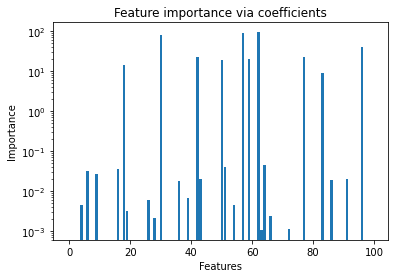

In [26]:
importance = np.abs(reg.coef_)
plt.bar(height=importance, x=range(0,n_features))
plt.title("Feature importance via coefficients")
plt.xlabel('Features')
plt.ylabel('Importance')
plt.yscale('log')
plt.show()

In [27]:
threshold = 0.1

mask = np.abs(reg.coef_) >= threshold

X = X[:,mask]

print('shape:', X.shape)

shape: (1000, 10)


In [28]:
alphas = np.logspace(-20,0,21)

reg = LassoCV(cv=5, alphas=alphas, random_state=seed)

reg.fit(X, y)

print('alpha:',reg.alpha_)
print('score:',reg.score(X, y))
print('MSE:',mean_squared_error(reg.predict(X),y))

alpha: 1e-15
score: 0.9999617003546654
MSE: 0.9868346791863092


In [29]:
reg = LinearRegression()

reg.fit(X,y)

print('score:',reg.score(X, y))
print('MSE:',mean_squared_error(reg.predict(X),y))

score: 0.9999617003564444
MSE: 0.9868346333476338


This output is immediately valuable. It's obvious that many of the weather features (either through not showing up sufficiently often or not telling us anything useful when they do) are adding nothing to our model and should be removed. In addition, we're not getting a lot of value from our traffic aggregates. While these can remain in for the moment (in the hope that gathering more data will improve their usefulness), for our next pass we'll rerun our model without the poorly-scoring features that our use of LASSO has revealed.

We see that a number of features have coefficient 0. If we increase α further, the solution would be sparser and sparser, i.e. more and more features would have 0 as coefficients.

Note however that L1 regularized regression is unstable in a similar way as unregularized linear models are, meaning that the coefficients (and thus feature ranks) can vary significantly even on small data changes when there are correlated features in the data. Which brings us to L2 regularization.

The practical benefit of this effect is that it means that we could include 100 features in our feature matrix and then, through adjusting lasso’s α hyperparameter, produce a model that uses only 10 (for instance) of the most important features. This lets us reduce variance while improving the interpretability of our model (since fewer features is easier to explain).